# DATA PROJECT: A dive into the Danish private sector

**TABLE OF CONTENTS**<a id='toc0_'></a>    
- [1. Project description](#toc1_)    
- [2. Imports and set magics](#toc2_) 
- [3. Read, clean and explore data](#toc3_)
    - 3.1. [Dataset GF02 - active firms given time, industry, size and region](#toc3_1_)
    - 3.2. [Dataset DEMO4 - start-ups and bankruptcies over time and for different industries](#toc3_2_)  
- [4. Merging the datasets](#toc4_)
- [5. Analysis](#toc5_)
- [6. Concluding remarks](#toc6_)
   

## 1. <a id='toc1_'></a>[Project description](#toc0_)

The idea behind the project is to... Emil + Simon

For the project we have decided to use data from Statistics Denmark (Statistikbanken). To get the data we will use their Api, DstApi.

## 2. <a id='toc2_'></a>[Imports and set magics](#toc0_)

In [1]:
# As we will use data from Statistics Denmark (Statistikbanken) we will be using the DstApi to access that data.
# If you previously have not installed it through github, the hashtag below should be deleted and the "%pip..." line should be run.
# More info the DstApi can be found by following the link below to the githhub page explaining the Api.

#%pip install git+https://github.com/alemartinello/dstapi


In [2]:
# We import different packages for the further analysis - among these the DstApi that has been installed via the code above.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
import datetime
import ipywidgets as widgets
from matplotlib_venn import venn2
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


## 3. <a id='toc3_'></a>[Read, clean and explore data](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Dataset GF02 - active firms given time, industry, size and region](#toc0_)

#### **Importing the dataset**

We have chosen to use the dataset [GF02](https://www.statistikbanken.dk/gf02) that contains the number of companies conditioned on area, industry (DB07), company size and year. The idea is to first examine the overall situation for the number of companies in Denmark over the period 2007-2021 depending on size and industry. From the link above, a few important things to mention are:
* The industries are determined based on Statistics Denmark industry code: DB07. We will primarily focus on the 10-grp. A link is [here](https://www.dst.dk/da/Statistik/dokumentation/nomenklaturer/db07#)
* 'No employed' means that only the founder of the company is regisered - an example could be a consultant with own cvr number.
* Industry code '11 Activity not stated' contains companies not defined by industry. We will take this into account later.

We start by examining the statistic using the link above, to get an idea of the expected data we will get from importing using the DstApi. Then we get an idea of how the [DstApi](https://github.com/alemartinello/dstapi) works. The following steps have been taken to import via the api:

In [3]:
#We start by extracting the data
gf02_api = DstApi('GF02') 

In [4]:
#We then get an overview of what it contains by using the tablesummary-method. We for instance see that we have the whole period (2007-21)
#We want to use tabsum get a more detailed view of the variables below.
tabsum = gf02_api.tablesummary(language='en')
display(tabsum)

Table GF02: General enterprise statistics by Municipality, Industry (DB07 10- 19- and 127 grouping and detailed), enterprise size (full time equivalents) and time
Last update: 2023-05-05T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KOMK,118,000,All Denmark,12,Outside from Denmark,False
1,BRANCHEDB0710TIL127,902,TOT,TOT Industry total,999999,999999 Activity not stated,False
2,FIRMSTR,6,TOT,"Total, all enterprises",103,250 employees and more,False
3,Tid,15,2007,2007,2021,2021,True


In [5]:
#We loop over the variables in column 'variable name' in tabsum to get a more detailed depiction of the structure of the variabels in english: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(gf02_api.variable_levels(variable, language='en'))

KOMK:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
113,820,Vesthimmerlands
114,851,Aalborg
115,099,Region unknown
116,098,Municipality unknown


BRANCHEDB0710TIL127:


,id,text
0,TOT,TOT Industry total
1,1,"1 Agriculture, forestry and fishing"
2,A,"A Agriculture, forestry and fishing"
3,01000,01000 Agriculture and horticulture
4,011100,"011100 Growing of cereals (except rice), legum..."
...,...,...
897,990000,990000 Activities of extraterritorial organiza...
898,11,11 Activity not stated
899,X,X Activity not stated
900,99999,99999 Activity not stated


FIRMSTR:


,id,text
0,TOT,"Total, all enterprises"
1,0000,No employed
2,010,Less than 10 employed
3,101,10-49 employees
4,102,50-249 employees
5,103,250 employees and more


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


In [6]:
#We now use the _define_base_params method to help make a dictionary for detailing the data we want.
params = gf02_api._define_base_params(language='en')
params

{'table': 'gf02',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOMK', 'values': ['*']},
  {'code': 'BRANCHEDB0710TIL127', 'values': ['*']},
  {'code': 'FIRMSTR', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [7]:
#We copy the output above and define the data we want using specific variable id's from above or extracting all using '*'.
params_gf02 = {'table': 'gf02',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOMK', 'values': ['000']}, #id 000 --> we look at companies in all of Denmark
  {'code': 'BRANCHEDB0710TIL127', 'values': ['TOT','1','2','3','4','5','6','7','8','9','10','11']}, #we look at all industries (10-grp) in Denmark (1-11) and the total (TOT).
  {'code': 'FIRMSTR', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [8]:
#We get the data using the parameters created above, store in gf02_all and see how the head of the table looks like.
gf02_all = gf02_api.get_data(params=params_gf02)
gf02_all.head(5)

,KOMK,BRANCHEDB0710TIL127,FIRMSTR,TID,INDHOLD
0,All Denmark,"1 Agriculture, forestry and fishing",No employed,2007,30932
1,All Denmark,"1 Agriculture, forestry and fishing",Less than 10 employed,2007,9129
2,All Denmark,"1 Agriculture, forestry and fishing",10-49 employees,2007,369
3,All Denmark,"1 Agriculture, forestry and fishing",50-249 employees,2007,21
4,All Denmark,"1 Agriculture, forestry and fishing",250 employees and more,2007,2


#### **Cleaning and renaming the dataset**

For the next part we want to rename the variables to something that is easier to understand and use later on. For us to easier explore the data later, we also want to be able to get an impression of the number of companies and changes throughout the period 2007-21 depending on either the size of companies or the industry they belong to. We do so by creating two datasets (gf02_size and gf02_industries) that we can explore later.

In [9]:
#We start by renaming the variables
gf02_all_rename = gf02_all.rename(columns = {'KOMK':'area','BRANCHEDB0710TIL127':'industry','FIRMSTR':'size', 'TID':'year', 'INDHOLD':'companies'})
gf02_all_rename

,area,industry,size,year,companies
0,All Denmark,"1 Agriculture, forestry and fishing",No employed,2007,30932
1,All Denmark,"1 Agriculture, forestry and fishing",Less than 10 employed,2007,9129
2,All Denmark,"1 Agriculture, forestry and fishing",10-49 employees,2007,369
3,All Denmark,"1 Agriculture, forestry and fishing",50-249 employees,2007,21
4,All Denmark,"1 Agriculture, forestry and fishing",250 employees and more,2007,2
...,...,...,...,...,...
1039,All Denmark,TOT Industry total,Less than 10 employed,2021,154138
1040,All Denmark,TOT Industry total,10-49 employees,2021,19594
1041,All Denmark,TOT Industry total,50-249 employees,2021,3945
1042,All Denmark,TOT Industry total,250 employees and more,2021,870


In [10]:
#We then create an index, I, so we in gf02_size only include and look at all of Denmark and the total for all industries
I = gf02_all_rename.area.str.contains('All Denmark') & gf02_all_rename.industry.str.contains('TOT Industry total')
gf02_size = gf02_all_rename.loc[I, :]
gf02_size
#Thus, we go from 1044 rows to 90 rows.

,area,industry,size,year,companies
66,All Denmark,TOT Industry total,No employed,2007,168183
67,All Denmark,TOT Industry total,Less than 10 employed,2007,111481
68,All Denmark,TOT Industry total,10-49 employees,2007,21004
69,All Denmark,TOT Industry total,50-249 employees,2007,3816
70,All Denmark,TOT Industry total,250 employees and more,2007,835
...,...,...,...,...,...
1039,All Denmark,TOT Industry total,Less than 10 employed,2021,154138
1040,All Denmark,TOT Industry total,10-49 employees,2021,19594
1041,All Denmark,TOT Industry total,50-249 employees,2021,3945
1042,All Denmark,TOT Industry total,250 employees and more,2021,870


In [11]:
#Cutting down the data we want to reset the index used above and correct the ID numbers. 
#We also drop the variables area and industry, as they now only contain the total for Denmark and total for the Danish industries.

gf02_size.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
gf02_size.iloc[0:67,:]
gf02_size_reduced = gf02_size.drop(['area','industry'], axis=1)
gf02_size_reduced

,size,year,companies
0,No employed,2007,168183
1,Less than 10 employed,2007,111481
2,10-49 employees,2007,21004
3,50-249 employees,2007,3816
4,250 employees and more,2007,835
...,...,...,...
85,Less than 10 employed,2021,154138
86,10-49 employees,2021,19594
87,50-249 employees,2021,3945
88,250 employees and more,2021,870


In [12]:
gf02_size_reduced.describe().round(2)

#The numbers do not say so much in this way, but we recognize, that we have 90 observations, the smallest number of companies being 750 and the largest 328445.

,year,companies
count,90.00,90.00
mean,2014.00,102664.00
std,4.34,111039.97
min,2007.00,750.00
25%,2010.00,3541.00
50%,2014.00,66242.50
75%,2018.00,152929.00
max,2021.00,328445.00


In [13]:
print(gf02_all_rename.dtypes)

area         object
industry     object
size         object
year          int64
companies     int64
dtype: object


In [14]:
#We now want to create the gf02_industries in the same way as we created gf02_size above.
#Since size is a property in pandas, we have to rename the last bit of the index compared to previously.
#We can thus solve it by writing gf02_all_rename['size']... rather than gf02_all_rename.size...

I = gf02_all_rename.area.str.contains('All Denmark') & gf02_all_rename['size'].str.contains('Total, all enterprises')
gf02_industries = gf02_all_rename.loc[I, :]
gf02_industries

,area,industry,size,year,companies
5,All Denmark,"1 Agriculture, forestry and fishing","Total, all enterprises",2007,40453
11,All Denmark,"10 Arts, entertainment and other services","Total, all enterprises",2007,18498
17,All Denmark,11 Activity not stated,"Total, all enterprises",2007,1484
23,All Denmark,"2 Manufacturing, mining and quarrying, and uti...","Total, all enterprises",2007,20814
29,All Denmark,3 Construction,"Total, all enterprises",2007,35547
...,...,...,...,...,...
1019,All Denmark,6 Financial and insurance,"Total, all enterprises",2021,15224
1025,All Denmark,7 Real estate,"Total, all enterprises",2021,30935
1031,All Denmark,8 Other business services,"Total, all enterprises",2021,59768
1037,All Denmark,"9 Public administration, education and health","Total, all enterprises",2021,28538


In [15]:
#We reset the index, allign the id and drop the area and size as they now only hold all of Denmark and total enterprises/companies.

gf02_industries.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
gf02_industries.iloc[0:6,:]
gf02_industries_reduced = gf02_industries.drop(['area','size'], axis=1)
gf02_industries_reduced

#We notice how the order of industries have been switched around (1, 10, 11... rather than 1, 2, 3...). 
#We later correct this in tables and plots.

,industry,year,companies
0,"1 Agriculture, forestry and fishing",2007,40453
1,"10 Arts, entertainment and other services",2007,18498
2,11 Activity not stated,2007,1484
3,"2 Manufacturing, mining and quarrying, and uti...",2007,20814
4,3 Construction,2007,35547
...,...,...,...
175,6 Financial and insurance,2021,15224
176,7 Real estate,2021,30935
177,8 Other business services,2021,59768
178,"9 Public administration, education and health",2021,28538


#### **Exploring the dataset**

To explore the dataset, we will go though each of the two subdatasets we have created, where we look at the number of companies in Denmark given by 1: their size and 2: the industry they belong to. We will do this by making a table and a graph or two for each subdataset. 

As the original dataset appears to be a long dataset, so does the subdatasets. In a long dataset, each row represents a single observation, in this case, the number of companies of a specific size or in a specific industry for a particular year. The variables 'size'/'industry', 'year', and 'companies' are structured in such a way that each observation is unique, with different sizes/industries and years being repeated across multiple rows. Thus, for the tables we will make a wide version of the subdatasets to get a table, that is easier to understand.

For the visual depiction, we will make some general plots in order to get and understanding of what can be researched further in the analysis.

In [16]:
#We make a wide dataset for a more clear table depiction.
#We reindex in a desired order as the program otherwise would make and order of size-names according to numbers and alphabetic order.

gf02_size_wide = pd.pivot(gf02_size_reduced, index='size', columns='year', values='companies')
gf02_size_wide = gf02_size_wide.reindex(['No employed', 
                                         'Less than 10 employed', 
                                         '10-49 employees', 
                                         '50-249 employees', 
                                         '250 employees and more', 
                                         'Total, all enterprises'])
gf02_size_wide

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
size,,,,,,,,,,,,,,,
No employed,168183,168010,156529,158551,160589,161036,153368,139273,134794,142595,144520,145036,147459,147315,149898
Less than 10 employed,111481,117855,116338,117684,118175,118479,123337,138907,140447,143122,145775,147930,150226,151612,154138
10-49 employees,21004,20998,19053,17917,17938,17911,17855,17449,17771,18110,18596,19349,19141,19093,19594
50-249 employees,3816,3814,3379,3170,3261,3293,3270,3384,3436,3512,3628,3798,3813,3825,3945
250 employees and more,835,841,773,759,770,764,751,750,790,818,812,857,855,850,870
"Total, all enterprises",305319,311518,296072,298081,300733,301483,298581,299763,297238,308157,313331,316970,321494,322695,328445


In [17]:
gf02_size_wide.describe().round(2)

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,101773.00,103839.33,98690.67,99360.33,100244.33,100494.33,99527.00,99921.00,99079.33,102719.00,104443.67,105656.67,107164.67,107565.00,109481.67
std,120202.49,122410.09,116301.71,117419.77,118519.14,118827.13,117286.56,117440.39,116338.44,120674.60,122655.17,123934.07,125814.51,126315.87,128519.95
min,835.00,841.00,773.00,759.00,770.00,764.00,751.00,750.00,790.00,818.00,812.00,857.00,855.00,850.00,870.00
25%,8113.00,8110.00,7297.50,6856.75,6930.25,6947.50,6916.25,6900.25,7019.75,7161.50,7370.00,7685.75,7645.00,7642.00,7857.25
50%,66242.50,69426.50,67695.50,67800.50,68056.50,68195.00,70596.00,78178.00,76282.50,80352.50,81558.00,82192.50,83300.00,83204.00,84746.00
75%,154007.50,155471.25,146481.25,148334.25,149985.50,150396.75,145860.25,139181.50,139033.75,142990.25,145461.25,147206.50,149534.25,150537.75,153078.00
max,305319.00,311518.00,296072.00,298081.00,300733.00,301483.00,298581.00,299763.00,297238.00,308157.00,313331.00,316970.00,321494.00,322695.00,328445.00


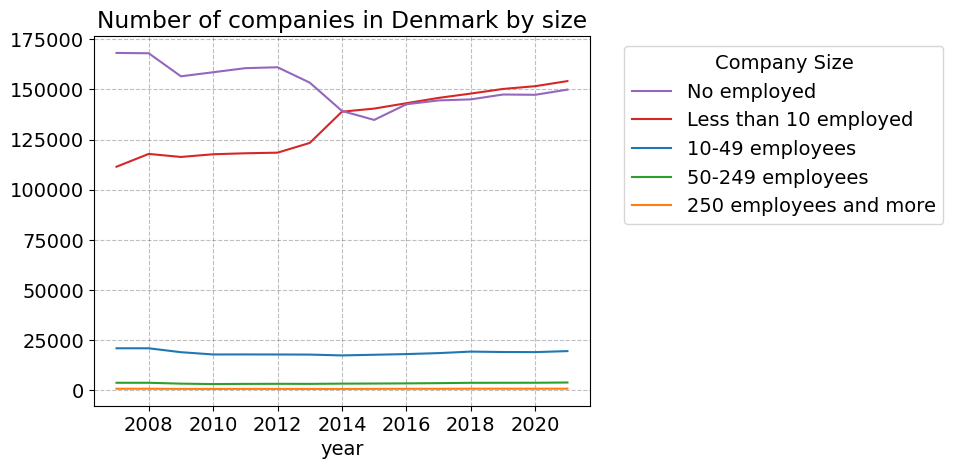

In [18]:
#We make a plot of companies of different sizes over the period.
#note, we remove 'Total, all enterprises' to make it easier to see changes over the years for individual company sizes.

ax = (gf02_size_reduced[gf02_size_reduced['size'] != 'Total, all enterprises'].reset_index()
    .pivot(index='year', columns='size', values='companies')
    .plot(title='Number of companies in Denmark by size'))

handles, labels = ax.get_legend_handles_labels()
# Here we specify the desired order for the legend labels
order_legend_size = ['No employed', 'Less than 10 employed', '10-49 employees', '50-249 employees', '250 employees and more']

# We create a new list of handles and labels in the desired order
handles_size = [handles[labels.index(label)] for label in order_legend_size]
labels_size = order_legend_size

plt.legend(title='Company Size', handles=handles_size, labels=labels_size, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Key takeaway:** 
* From the table we see that the total number of companies in Denmark for the period 2007-21 is between a low of approx 296.000 (2009) and a high of approx 328.500 (2021). The number of companies fell after the financial crisis in 2008-09 and stayed at a low level after it started increasing from around 2015.
* Not surprisingly the there are generally fewer medium-sized and big companies overall.
* All company-size groups have seen a drop after the financial crisis. However, the drop has been minor and briefly for the companies with less than 10 employed. On the other hand, the group of no employed has seen a drop until 2015. This can suggest, that some of the founders have chosen to close their business and take a job elsewhere. However, the growing number of companies with less than 10 employed, can also suggest that some of the companies with only the founder have succeeded in growing and hireing new employees, thus raising themselves from the 'No employed' category to the 'Less than 10 employed'.

To get a better understanding of the individual company-sizes we can make an interactive plot using widgets:

In [19]:
def plot_gf02_size(df, size): 
    I = df['size'] == size
    ax=df.loc[I,:].plot(x='year', y='companies', style='-o', legend=False)

In [20]:
widgets.interact(plot_gf02_size, 
    df = widgets.fixed(gf02_size),
    size = widgets.Dropdown(description='Size', 
                            options=gf02_size['size'].unique(), 
                            value='Total, all enterprises')
);

interactive(children=(Dropdown(description='Size', index=5, options=('No employed', 'Less than 10 employed', '…

**Key takeaway:** 
* Looking through the different size groups we see, that for the most part, there has been a tendency to an increasing number of companies from around 2014-15 and onwards. This suggests 1: more companies have been started around that time, and 2: companies already excisting have been able to hire more employees and grow to a larger company-size.
* The effects of the financial crisis becomes more evident looking at the groups individually, and thus, also how the 'Less than 10 employed' have been hit very mildly compared to the others.

We now want to do the same looking at companies in different industries using the subdataset gf02_industries constructed for the purpose. Again we create a wide dataset to get a table that is easier to read and then we plot the number of companies over the period for the industries.

In [21]:
#Same approach as for gf02_size
gf02_industries_wide = pd.pivot(gf02_industries_reduced, index='industry', columns='year', values='companies')
gf02_industries_wide = gf02_industries_wide.reindex(['1 Agriculture, forestry and fishing', 
                                         '2 Manufacturing, mining and quarrying, and utility services', 
                                         '3 Construction', 
                                         '4 Trade and transport etc.', 
                                         '5 Information and communication', 
                                         '6 Financial and insurance',
                                         '7 Real estate',
                                         '8 Other business services',
                                         '9 Public administration, education and health',
                                         '10 Arts, entertainment and other services',
                                         '11 Activity not stated',
                                         'TOT Industry total'])
gf02_industries_wide

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
industry,,,,,,,,,,,,,,,
"1 Agriculture, forestry and fishing",40453,38178,35176,34143,32705,32571,30722,29631,27618,27411,26185,26217,25835,25944,25428
"2 Manufacturing, mining and quarrying, and utility services",20814,20986,20349,20155,20312,20228,19667,19584,19341,19610,19698,19747,19840,19629,19636
3 Construction,35547,36024,33135,31588,31575,31300,30707,31280,31197,31973,32643,33306,33937,34756,35949
4 Trade and transport etc.,76256,74640,70950,71035,70428,69508,67656,66781,65635,66816,67559,67121,67149,66412,67232
5 Information and communication,11384,12217,12388,13597,14588,14962,15409,16109,16109,17130,17992,18492,18970,19003,19448
6 Financial and insurance,7720,10948,8602,9336,8983,9169,9301,10050,10943,12045,12818,13600,14141,14486,15224
7 Real estate,26176,26842,24489,24664,27220,27398,27574,27464,26935,28448,29216,29654,29644,30296,30935
8 Other business services,43195,44759,43267,45520,47637,48347,48810,50021,50038,53054,54721,55923,57584,57904,59768
"9 Public administration, education and health",23792,25064,26273,25653,24272,24676,25257,25039,25495,26495,26887,26992,27669,28139,28538


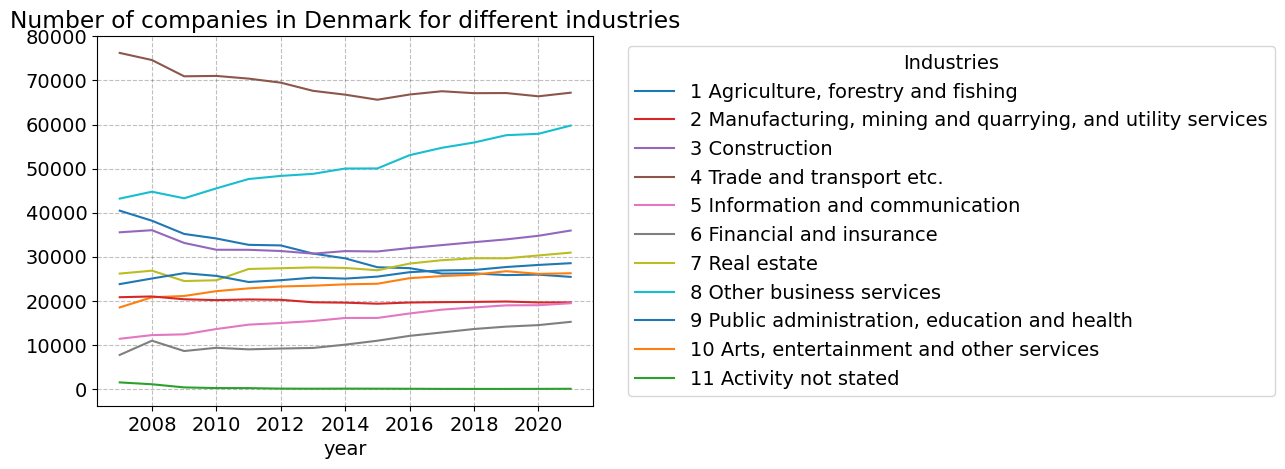

In [22]:
#We again make a plot, where we remove the total, so the plot is easier to "read".
ax = (gf02_industries_reduced[gf02_industries_reduced['industry'] != 'TOT Industry total'].reset_index()
    .pivot(index='year', columns='industry', values='companies')
    .plot(title='Number of companies in Denmark for different industries'))

handles, labels = ax.get_legend_handles_labels()
# Here we specify the desired order for the legend labels
order_legend_industries = ['1 Agriculture, forestry and fishing', 
                           '2 Manufacturing, mining and quarrying, and utility services', 
                           '3 Construction', 
                           '4 Trade and transport etc.', 
                           '5 Information and communication', 
                           '6 Financial and insurance',
                           '7 Real estate',
                           '8 Other business services',
                           '9 Public administration, education and health',
                           '10 Arts, entertainment and other services',
                           '11 Activity not stated']

# We create a new list of handles and labels in the desired order
handles_industries = [handles[labels.index(label)] for label in order_legend_industries]
labels_industries = order_legend_industries

plt.legend(title='Industries', handles=handles_industries, labels=labels_industries, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Key takeaway:** 
* From the table and the plot we see, that the trade and transport industry has the most companies in Denmark while the smallest number of companies are within financial and insurance (not including those where industry is not stated).
* There seems to have been a negative trend in the number of trade and transporting companies in general since 2007 which can suggest less activity in that industry in general or that fewer can do what previously took more companies.
* We see a similar trend in argiculture, forestry and fishing, which, given production is the same, can suggest that 1: fewer companies can produce the same (increasing productivity) or 2: larger companies operate larger amounts of land, forrest or fishing quotas.
* Not surprisingly we see a drop in construction companies after the financial crisis as we could expect from postponed building projects until better economic times (or increased government spending on infrastructure etc.).
* Only 'Information and communication' and 'Arts, entertainment and other services' seems to have been unaffected by the financial crisis in 2008-09 when looking at the number of companies. For IT this could be explained by the continuous trend of the economy and industries in general becoming more technological or low costs to start a business in that industry.


### 3.2. <a id='toc3_2_'></a>[Dataset DEMO4 - start-ups and bankruptcies over time and for different industries](#toc0_)

#### Importing the dataset

As we are using another dataset from Statistics Denmark, we apply the same approach as described with the previous dataset (GF02).

In [23]:
# creating a a dst api
demo4_api = DstApi('DEMO4')

In [24]:
# displaing the data 
tabsum2 = demo4_api.tablesummary(language='en')
display(tabsum2)

Table DEMO4: Business Demography by region, industry (DB07 10-grouping), unit and time
Last update: 2023-05-16T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,REGION,6,000,All Denmark,081,Region Nordjylland,False
1,BRANCHEDB0710,12,TOT,TOT Industry total,11,11 Activity not stated,False
2,MÆNGDE4,5,AFU,Employees (in full-time persons),NYE,New enterprises (number),False
3,Tid,15,2007,2007,2021,2021,True


In [25]:
# a overview of the available values for a each variable: 
for variable in tabsum2['variable name']:
    print(variable+':')
    display(demo4_api.variable_levels(variable, language='en'))

REGION:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,085,Region Sjælland
3,083,Region Syddanmark
4,082,Region Midtjylland
5,081,Region Nordjylland


BRANCHEDB0710:


,id,text
0,TOT,TOT Industry total
1,1,"1 Agriculture, forestry and fishing"
2,2,"2 Manufacturing, mining and quarrying, and uti..."
3,3,3 Construction
4,4,4 Trade and transport etc.
5,5,5 Information and communication
6,6,6 Financial and insurance
7,7,7 Real estate
8,8,8 Other business services
9,9,"9 Public administration, education and health"


MÆNGDE4:


,id,text
0,AFU,Employees (in full-time persons)
1,OPH,Number of terminated enterprises
2,OMS1,Turnover (DKK 1000)
3,EKS1,Export (DKK 1000)
4,NYE,New enterprises (number)


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


In [26]:
# defining a dictionary for the parameters
params_demo4 = demo4_api._define_base_params(language='en')
params_demo4

{'table': 'demo4',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'REGION', 'values': ['*']},
  {'code': 'BRANCHEDB0710', 'values': ['*']},
  {'code': 'MÆNGDE4', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [27]:
# from here we can choose the parameters we want to examine. For now we just choose all (*)
params_demo4 = {'table': 'demo4',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'REGION', 'values': ['*']},
  {'code': 'BRANCHEDB0710', 'values': ['*']},
  {'code': 'MÆNGDE4', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [28]:
# loading the data from dst
demo4_all = demo4_api.get_data(params=params_demo4)
demo4_all.head(5)

,REGION,BRANCHEDB0710,MÆNGDE4,TID,INDHOLD
0,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",New enterprises (number),2016,346
1,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",Turnover (DKK 1000),2016,487320
2,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",Number of terminated enterprises,2016,366
3,Region Midtjylland,3 Construction,Employees (in full-time persons),2016,186
4,Region Midtjylland,3 Construction,Export (DKK 1000),2016,..


#### Cleaning and renaming the dataset

Introduction to next step: DEMO4

In [29]:
# renaming the collums
demo4_all.rename(columns = {'REGION':'regions','BRANCHEDB0710':'industry', 'MÆNGDE4': 'x', 'TID':'year', 'INDHOLD':'total'}, inplace=True)
demo4_all.head()

,regions,industry,x,year,total
0,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",New enterprises (number),2016,346
1,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",Turnover (DKK 1000),2016,487320
2,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",Number of terminated enterprises,2016,366
3,Region Midtjylland,3 Construction,Employees (in full-time persons),2016,186
4,Region Midtjylland,3 Construction,Export (DKK 1000),2016,..


In [30]:
# selecting the parameters we wnat to exmine
I = demo4_all.regions.str.contains('All Denmark') & demo4_all.industry.str.contains('TOT Industry total')
demo4_reduce = demo4_all.loc[I, :]
demo4_reduce

,regions,industry,x,year,total
213,All Denmark,TOT Industry total,Employees (in full-time persons),2016,8426
214,All Denmark,TOT Industry total,Export (DKK 1000),2016,..
215,All Denmark,TOT Industry total,New enterprises (number),2016,34116
216,All Denmark,TOT Industry total,Turnover (DKK 1000),2016,23556132
217,All Denmark,TOT Industry total,Number of terminated enterprises,2016,27476
...,...,...,...,...,...
5145,All Denmark,TOT Industry total,Employees (in full-time persons),2017,8324
5146,All Denmark,TOT Industry total,Export (DKK 1000),2017,..
5147,All Denmark,TOT Industry total,New enterprises (number),2017,33839
5148,All Denmark,TOT Industry total,Turnover (DKK 1000),2017,22395684


In [31]:
# resetting the index
demo4_reduce.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
demo4_reduce.iloc[0:81,:]
demo4_reduce

,regions,industry,x,year,total
0,All Denmark,TOT Industry total,Employees (in full-time persons),2016,8426
1,All Denmark,TOT Industry total,Export (DKK 1000),2016,..
2,All Denmark,TOT Industry total,New enterprises (number),2016,34116
3,All Denmark,TOT Industry total,Turnover (DKK 1000),2016,23556132
4,All Denmark,TOT Industry total,Number of terminated enterprises,2016,27476
...,...,...,...,...,...
70,All Denmark,TOT Industry total,Employees (in full-time persons),2017,8324
71,All Denmark,TOT Industry total,Export (DKK 1000),2017,..
72,All Denmark,TOT Industry total,New enterprises (number),2017,33839
73,All Denmark,TOT Industry total,Turnover (DKK 1000),2017,22395684


In [32]:
# del
drop_this = ['regions']
print(drop_this)
demo4_reduce.drop(drop_this, axis=1, inplace=True)
demo4_reduce.head(5)

['regions']


C:\Users\EmilW\AppData\Local\Temp\ipykernel_10252\3500178100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo4_reduce.drop(drop_this, axis=1, inplace=True)


,industry,x,year,total
0,TOT Industry total,Employees (in full-time persons),2016,8426
1,TOT Industry total,Export (DKK 1000),2016,..
2,TOT Industry total,New enterprises (number),2016,34116
3,TOT Industry total,Turnover (DKK 1000),2016,23556132
4,TOT Industry total,Number of terminated enterprises,2016,27476


#### Exploring the dataset

Introduction to next step:

In [33]:
demo4_wide = demo4_reduce.pivot(index='x', columns='year', values='total')
demo4_wide

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
x,,,,,,,,,,,,,,,
Employees (in full-time persons),16081,11856,8786,9213,9858,8679,9386,9719,9523,8426,8324,8041,9078,9411,10025
Export (DKK 1000),2951529,3027391,2590263,1874870,..,..,..,..,..,..,..,..,..,..,..
New enterprises (number),36660,37197,27024,30799,33659,30696,28998,31089,29911,34116,33839,33295,33930,34779,35679
Number of terminated enterprises,31768,42386,37653,32278,30719,31775,31994,30989,32949,27476,30523,31294,31297,33159,37492
Turnover (DKK 1000),47073838,45228939,23798453,23151134,27691573,30122204,30389184,24049108,24637820,23556132,22395684,21440497,23180665,31893845,29600351


In [34]:
print(demo4_reduce.dtypes)

industry    object
x           object
year         int64
total       object
dtype: object


In [35]:
# Convert 'total' column to numeric type, coercing errors to NaN
demo4_reduce['total'] = pd.to_numeric(demo4_reduce['total'], errors='coerce')

# Check for NaN values after conversion
print(demo4_reduce[demo4_reduce['total'].isna()])

              industry                  x  year  total
1   TOT Industry total  Export (DKK 1000)  2016    NaN
11  TOT Industry total  Export (DKK 1000)  2019    NaN
18  TOT Industry total  Export (DKK 1000)  2011    NaN
28  TOT Industry total  Export (DKK 1000)  2012    NaN
33  TOT Industry total  Export (DKK 1000)  2015    NaN
36  TOT Industry total  Export (DKK 1000)  2021    NaN
41  TOT Industry total  Export (DKK 1000)  2020    NaN
53  TOT Industry total  Export (DKK 1000)  2014    NaN
63  TOT Industry total  Export (DKK 1000)  2013    NaN
66  TOT Industry total  Export (DKK 1000)  2018    NaN
71  TOT Industry total  Export (DKK 1000)  2017    NaN


C:\Users\EmilW\AppData\Local\Temp\ipykernel_10252\2027707119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo4_reduce['total'] = pd.to_numeric(demo4_reduce['total'], errors='coerce')


Key takeaway: DEMO4

## 4. <a id='toc4_'></a>[Merging the datasets](#toc0_)

Both of the datasets have the industries in common. We therefore want to adapt them, so that we can merge them on industries. This will give us the number of companies for different industries from GF02 and the employees, export, new enterprises/companies, turnover and number of terminated enterprises/companies from DEMO4. For the further analysis we are especially interested in the number of new and the number of terminated enterprises/companies.

In [36]:
#We will create a subset of DEMO4 where we include the industries (the same as we have done for gf02_industries above)

I = demo4_all.regions.str.contains('All Denmark')
demo4_industries = demo4_all.loc[I, :]
demo4_industries

,regions,industry,x,year,total
213,All Denmark,TOT Industry total,Employees (in full-time persons),2016,8426
214,All Denmark,TOT Industry total,Export (DKK 1000),2016,..
215,All Denmark,TOT Industry total,New enterprises (number),2016,34116
216,All Denmark,TOT Industry total,Turnover (DKK 1000),2016,23556132
217,All Denmark,TOT Industry total,Number of terminated enterprises,2016,27476
...,...,...,...,...,...
5200,All Denmark,"9 Public administration, education and health",Employees (in full-time persons),2017,530
5201,All Denmark,"9 Public administration, education and health",Export (DKK 1000),2017,..
5202,All Denmark,"9 Public administration, education and health",New enterprises (number),2017,2585
5203,All Denmark,"9 Public administration, education and health",Turnover (DKK 1000),2017,784596


In [37]:
# We reset the index to start with 0.

demo4_industries.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
demo4_industries.iloc[0:81,:]
demo4_industries

,regions,industry,x,year,total
0,All Denmark,TOT Industry total,Employees (in full-time persons),2016,8426
1,All Denmark,TOT Industry total,Export (DKK 1000),2016,..
2,All Denmark,TOT Industry total,New enterprises (number),2016,34116
3,All Denmark,TOT Industry total,Turnover (DKK 1000),2016,23556132
4,All Denmark,TOT Industry total,Number of terminated enterprises,2016,27476
...,...,...,...,...,...
895,All Denmark,"9 Public administration, education and health",Employees (in full-time persons),2017,530
896,All Denmark,"9 Public administration, education and health",Export (DKK 1000),2017,..
897,All Denmark,"9 Public administration, education and health",New enterprises (number),2017,2585
898,All Denmark,"9 Public administration, education and health",Turnover (DKK 1000),2017,784596


In [38]:
# We drop 'regions' as it is for the whole of Denmark.

drop_this = ['regions']
print(drop_this)
demo4_industries.drop(drop_this, axis=1, inplace=True)
demo4_industries

['regions']


C:\Users\EmilW\AppData\Local\Temp\ipykernel_10252\91161343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo4_industries.drop(drop_this, axis=1, inplace=True)


,industry,x,year,total
0,TOT Industry total,Employees (in full-time persons),2016,8426
1,TOT Industry total,Export (DKK 1000),2016,..
2,TOT Industry total,New enterprises (number),2016,34116
3,TOT Industry total,Turnover (DKK 1000),2016,23556132
4,TOT Industry total,Number of terminated enterprises,2016,27476
...,...,...,...,...
895,"9 Public administration, education and health",Employees (in full-time persons),2017,530
896,"9 Public administration, education and health",Export (DKK 1000),2017,..
897,"9 Public administration, education and health",New enterprises (number),2017,2585
898,"9 Public administration, education and health",Turnover (DKK 1000),2017,784596


In [39]:
# We have to pivot the dataframe, demo4_industries, to unpack the values of 'x' into individual columns
demo4_unpacked_merge = demo4_industries.pivot(index=['industry', 'year'], columns='x', values='total').reset_index()
demo4_unpacked_merge.columns.name = None
demo4_unpacked_merge

,industry,year,Employees (in full-time persons),Export (DKK 1000),New enterprises (number),Number of terminated enterprises,Turnover (DKK 1000)
0,"1 Agriculture, forestry and fishing",2007,389,96064,2458,3917,2382060
1,"1 Agriculture, forestry and fishing",2008,324,109968,2264,5001,2387493
2,"1 Agriculture, forestry and fishing",2009,282,64249,1584,3936,1490702
3,"1 Agriculture, forestry and fishing",2010,236,19883,1661,2885,1117631
4,"1 Agriculture, forestry and fishing",2011,291,..,2220,2278,1453093
...,...,...,...,...,...,...,...
175,TOT Industry total,2017,8324,..,33839,30523,22395684
176,TOT Industry total,2018,8041,..,33295,31294,21440497
177,TOT Industry total,2019,9078,..,33930,31297,23180665
178,TOT Industry total,2020,9411,..,34779,33159,31893845


In [40]:
#We sort gf02_industries, so it is equal to how demo4 is displayed above

gf02_industries_merge = gf02_industries_reduced.sort_values(['industry','year'])
gf02_industries_merge.reset_index(inplace = True, drop = True)
gf02_industries_merge

,industry,year,companies
0,"1 Agriculture, forestry and fishing",2007,40453
1,"1 Agriculture, forestry and fishing",2008,38178
2,"1 Agriculture, forestry and fishing",2009,35176
3,"1 Agriculture, forestry and fishing",2010,34143
4,"1 Agriculture, forestry and fishing",2011,32705
...,...,...,...
175,TOT Industry total,2017,313331
176,TOT Industry total,2018,316970
177,TOT Industry total,2019,321494
178,TOT Industry total,2020,322695


In [55]:
#We do an outer merge using pandas on industry and year. Both dataframes are long. More explanation of merge-method below.

gf02_demo4_merged = pd.merge(gf02_industries_merge, demo4_unpacked_merge, on=['industry', 'year'], how='outer')
gf02_demo4_merged

,industry,year,companies,Employees (in full-time persons),Export (DKK 1000),New enterprises (number),Number of terminated enterprises,Turnover (DKK 1000)
0,"1 Agriculture, forestry and fishing",2007,40453,389,96064,2458,3917,2382060
1,"1 Agriculture, forestry and fishing",2008,38178,324,109968,2264,5001,2387493
2,"1 Agriculture, forestry and fishing",2009,35176,282,64249,1584,3936,1490702
3,"1 Agriculture, forestry and fishing",2010,34143,236,19883,1661,2885,1117631
4,"1 Agriculture, forestry and fishing",2011,32705,291,..,2220,2278,1453093
...,...,...,...,...,...,...,...,...
175,TOT Industry total,2017,313331,8324,..,33839,30523,22395684
176,TOT Industry total,2018,316970,8041,..,33295,31294,21440497
177,TOT Industry total,2019,321494,9078,..,33930,31297,23180665
178,TOT Industry total,2020,322695,9411,..,34779,33159,31893845


In [42]:
#We rename the variables

gf02_demo4_merged = gf02_demo4_merged.rename(columns={
    'Employees (in full-time persons)': 'employees(fulltime)',
    'Export (DKK 1000)': 'Export(DKK1000)',
    'New enterprises (number)': 'startups',
    'Number of terminated enterprises': 'bankruptcies',
    'Turnover (DKK 1000)': 'Turnover(DKK1000)'
})

gf02_demo4_merged

,industry,year,companies,employees(fulltime),Export(DKK1000),startups,bankruptcies,Turnover(DKK1000)
0,"1 Agriculture, forestry and fishing",2007,40453,389,96064,2458,3917,2382060
1,"1 Agriculture, forestry and fishing",2008,38178,324,109968,2264,5001,2387493
2,"1 Agriculture, forestry and fishing",2009,35176,282,64249,1584,3936,1490702
3,"1 Agriculture, forestry and fishing",2010,34143,236,19883,1661,2885,1117631
4,"1 Agriculture, forestry and fishing",2011,32705,291,..,2220,2278,1453093
...,...,...,...,...,...,...,...,...
175,TOT Industry total,2017,313331,8324,..,33839,30523,22395684
176,TOT Industry total,2018,316970,8041,..,33295,31294,21440497
177,TOT Industry total,2019,321494,9078,..,33930,31297,23180665
178,TOT Industry total,2020,322695,9411,..,34779,33159,31893845


**Key takeaway:** As we in the have made the dataframes so similarly structured when sorted by industry and year, it does not make any difference in the merged dataframe above, gf02_demo4_merged, whether we use an outer, inner or left merge. In either case we have the variables from the one dataframe added to the other for a combined long dataset of 180 rows and 8 columns. Had we for instance not removed the firm-size, it could have made sense to do a different merge to keep data in either or both frames (outer merge), data that are only in both sets (inner merge) or data that are in the left or both datasets (left merge).

## 5. <a id='toc5_'></a>[Analysis](#toc0_)

After having been inspecting gf02 on size of companies and industries, for the further analysis we have constructed a plot where we can condition on both size and industry, to further examine some of the previous findings. To do this, we use the gf02_all_rename rather than our merged dataset, as it contains number of firms depending on size and industry.

In [43]:
#We define a function, where we filter by size and industry, so we can construct a widget with two dropdowns below.
def plot_gf02_all_rename(df, size, industry): 
    filtered_df = df[(df['size'] == size) & (df['industry'] == industry)]
    ax=filtered_df.plot(x='year', y='companies', style='-o', legend=False)

In [44]:
widgets.interact(plot_gf02_all_rename, 
    df = widgets.fixed(gf02_all_rename),
    industry=widgets.Dropdown(description='Industry', options=gf02_all_rename['industry'].unique(), value='1 Agriculture, forestry and fishing'),
    size = widgets.Dropdown(description='Size', options=gf02_all_rename['size'].unique(), value='Total, all enterprises')
);

interactive(children=(Dropdown(description='Size', index=5, options=('No employed', 'Less than 10 employed', '…

**Key takeaway:** focusing on the findings from earlier, by clicking through combinations of size and industry we see:
* df

Introduction to next step: Simon

In [45]:
def plot_demo4_wide(df, x): 
    I = df['x'] == x
    ax = df.loc[I,:].sort_values('year').plot(x='year', y='total', style='-o', legend=False)


In [46]:
widgets.interact(plot_demo4_wide, 
    df = widgets.fixed(demo4_reduce),
    x = widgets.Dropdown(description='total', 
                            options=demo4_reduce['x'].unique(), 
                            value='Employees (in full-time persons)')
);

interactive(children=(Dropdown(description='total', options=('Employees (in full-time persons)', 'Export (DKK …

Key takeaway: Simon

Introduction to next step: Simon

In [47]:
# Convert relevant columns to numeric data type
gf02_demo4_merged['startups'] = pd.to_numeric(gf02_demo4_merged['startups'], errors='coerce')
gf02_demo4_merged['bankruptcies'] = pd.to_numeric(gf02_demo4_merged['bankruptcies'], errors='coerce')
gf02_demo4_merged['companies'] = pd.to_numeric(gf02_demo4_merged['companies'], errors='coerce')

# Calculate survival rate
gf02_demo4_merged['survival_rate'] = gf02_demo4_merged['startups'] / gf02_demo4_merged['bankruptcies']

# Calculate startup rate
gf02_demo4_merged['startup_rate'] = gf02_demo4_merged['startups'] / gf02_demo4_merged['companies']

# Display the DataFrame
gf02_demo4_merged

,industry,year,companies,employees(fulltime),Export(DKK1000),startups,bankruptcies,Turnover(DKK1000),survival_rate,startup_rate
0,"1 Agriculture, forestry and fishing",2007,40453,389,96064,2458,3917,2382060,0.627521,0.060762
1,"1 Agriculture, forestry and fishing",2008,38178,324,109968,2264,5001,2387493,0.452709,0.059301
2,"1 Agriculture, forestry and fishing",2009,35176,282,64249,1584,3936,1490702,0.402439,0.045031
3,"1 Agriculture, forestry and fishing",2010,34143,236,19883,1661,2885,1117631,0.575737,0.048648
4,"1 Agriculture, forestry and fishing",2011,32705,291,..,2220,2278,1453093,0.974539,0.067880
...,...,...,...,...,...,...,...,...,...,...
175,TOT Industry total,2017,313331,8324,..,33839,30523,22395684,1.108639,0.107998
176,TOT Industry total,2018,316970,8041,..,33295,31294,21440497,1.063942,0.105041
177,TOT Industry total,2019,321494,9078,..,33930,31297,23180665,1.084129,0.105539
178,TOT Industry total,2020,322695,9411,..,34779,33159,31893845,1.048856,0.107777


Introduction to next step: Simon

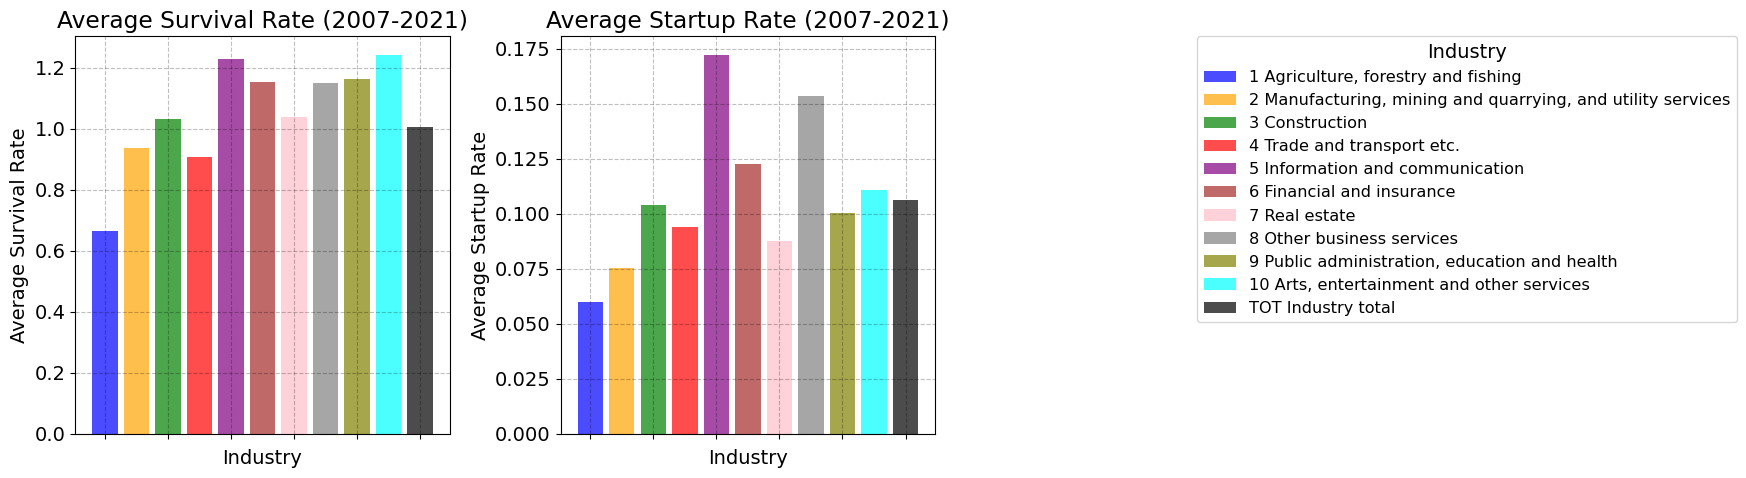

In [48]:
# We have removed '11 Activity not stated'
industries_of_interest = ['1 Agriculture, forestry and fishing', 
                          '2 Manufacturing, mining and quarrying, and utility services', 
                          '3 Construction', 
                          '4 Trade and transport etc.', 
                          '5 Information and communication', 
                          '6 Financial and insurance',
                          '7 Real estate',
                          '8 Other business services',
                          '9 Public administration, education and health',
                          '10 Arts, entertainment and other services',
                          'TOT Industry total']

# Define colors for each industry
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple', 'Brown', 'Pink', 'Gray', 'Olive', 'Cyan', 'Black']

# Create subplots for survival rate and startup rate
fig, axes = plt.subplots(1, 2, figsize=(20,5))

# Plot average survival rate
plt.subplot(1, 2, 1)
for i, industry in enumerate(industries_of_interest):
    avg_survival_rate = gf02_demo4_merged[gf02_demo4_merged['industry'] == industry]['survival_rate'].mean()
    plt.bar(i, avg_survival_rate, color=colors[i], label=industry, alpha=0.7)
plt.xlabel('Industry')
plt.ylabel('Average Survival Rate')
plt.title('Average Survival Rate (2007-2021)')
plt.gca().set_xticklabels([])

# Plot average startup rate
plt.subplot(1, 2, 2)
for i, industry in enumerate(industries_of_interest):
    avg_startup_rate = gf02_demo4_merged[gf02_demo4_merged['industry'] == industry]['startup_rate'].mean()
    plt.bar(i, avg_startup_rate, color=colors[i], label=industry, alpha=0.7)
plt.xlabel('Industry')
plt.ylabel('Average Startup Rate')
plt.title('Average Startup Rate (2007-2021)')
plt.gca().set_xticklabels([])

# Add a common legend
plt.legend(title='Industry', bbox_to_anchor=(1.7, 1), loc='upper left', borderaxespad=0., fontsize='small')

plt.tight_layout()
plt.show()


Key takeaway: Simon

Introduction to next step: Simon

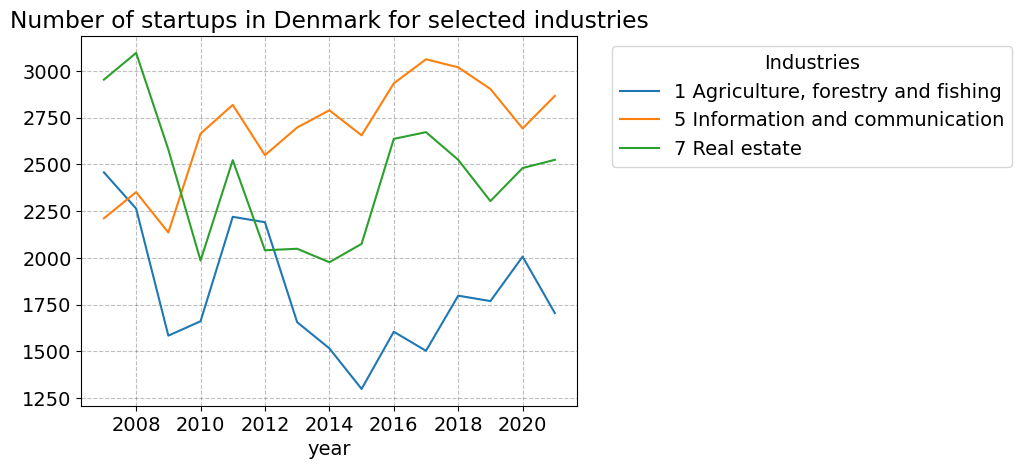

In [49]:
selected_industries = ['1 Agriculture, forestry and fishing', 
                       '5 Information and communication', 
                       '7 Real estate']
filtered_df = gf02_demo4_merged[gf02_demo4_merged['industry'].isin(selected_industries)]

ax = (filtered_df.reset_index()
      .pivot(index='year', columns='industry', values='startups')
      .plot(title='Number of startups in Denmark for selected industries'))

handles, labels = ax.get_legend_handles_labels()
order_legend_industries = selected_industries

handles_industries = [handles[labels.index(label)] for label in order_legend_industries]
labels_industries = order_legend_industries

plt.legend(title='Industries', handles=handles_industries, labels=labels_industries, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Key takeaway: Simon

Introduction to next step: Simon

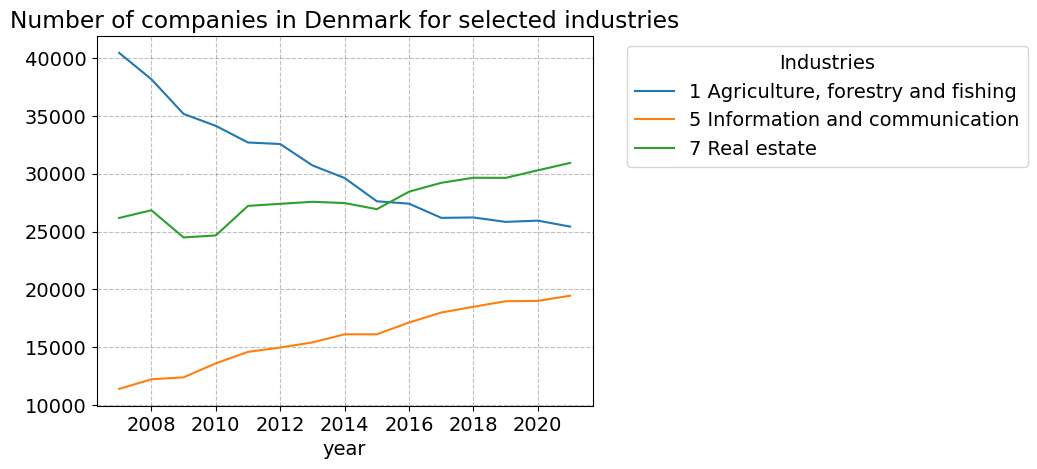

In [50]:
selected_industries = ['1 Agriculture, forestry and fishing', 
                       '5 Information and communication', 
                       '7 Real estate']
filtered_df = gf02_demo4_merged[gf02_demo4_merged['industry'].isin(selected_industries)]

ax = (filtered_df.reset_index()
      .pivot(index='year', columns='industry', values='companies')
      .plot(title='Number of companies in Denmark for selected industries'))

handles, labels = ax.get_legend_handles_labels()
order_legend_industries = selected_industries

handles_industries = [handles[labels.index(label)] for label in order_legend_industries]
labels_industries = order_legend_industries

plt.legend(title='Industries', handles=handles_industries, labels=labels_industries, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Key takeaway: Simon

## 6. <a id='toc6_'></a>[Concluding remarks](#toc0_)

Conclusion (method/programming + analysis/numbers) + what could we do next/change? Simon